In [2]:
import pandas as pd
file_path = "/Users/ZHANGRY/Codes/Notebook_Files/Decision_Analytics/DABP-Project-Decarbonization/Time-series forecast/demand for electricity/electricity demand.ipynb"
df = pd.read_excel(file_path)
df['consumption'] = df['consumption'] * (10**6) # in kwh
df.head()

,year,consumption
0,2000,2.793196e+11
1,2001,2.854919e+11
2,2002,2.909596e+11
3,2003,2.997886e+11
4,2004,3.044897e+11


In [3]:
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.head()

,year,consumption
0,2000-01-01,2.793196e+11
1,2001-01-01,2.854919e+11
2,2002-01-01,2.909596e+11
3,2003-01-01,2.997886e+11
4,2004-01-01,3.044897e+11


<AxesSubplot:xlabel='year', ylabel='consumption'>

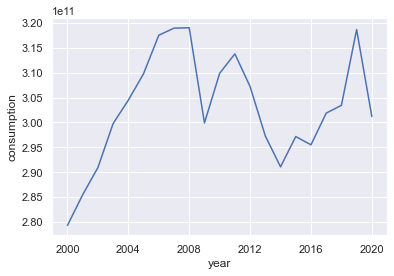

In [4]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Plot the responses for different events and region
sns.lineplot(x="year", y="consumption", data=df)

In [5]:
df['consumption'].dropna()

0     2.793196e+11
1     2.854919e+11
2     2.909596e+11
3     2.997886e+11
4     3.044897e+11
5     3.098168e+11
6     3.175332e+11
7     3.189525e+11
8     3.190372e+11
9     2.999152e+11
10    3.098845e+11
11    3.137921e+11
12    3.072195e+11
13    2.972876e+11
14    2.910835e+11
15    2.971799e+11
16    2.955083e+11
17    3.018805e+11
18    3.034430e+11
19    3.186696e+11
20    3.012000e+11
Name: consumption, dtype: float64

In [6]:
# stationary test
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
series = df['consumption'].dropna()
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.719432
p-value: 0.070736
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651


Using Augmented Dickey-Fuller test, cannot Reject the null hypothesis (H0), the data has a unit root and is stationary.
Reference:
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

In [7]:
df1 = df['consumption'].diff().dropna()
df1

1     6.172300e+09
2     5.467700e+09
3     8.829000e+09
4     4.701100e+09
5     5.327100e+09
6     7.716400e+09
7     1.419300e+09
8     8.470000e+07
9    -1.912200e+10
10    9.969300e+09
11    3.907600e+09
12   -6.572600e+09
13   -9.931900e+09
14   -6.204100e+09
15    6.096400e+09
16   -1.671600e+09
17    6.372200e+09
18    1.562500e+09
19    1.522660e+10
20   -1.746960e+10
Name: consumption, dtype: float64

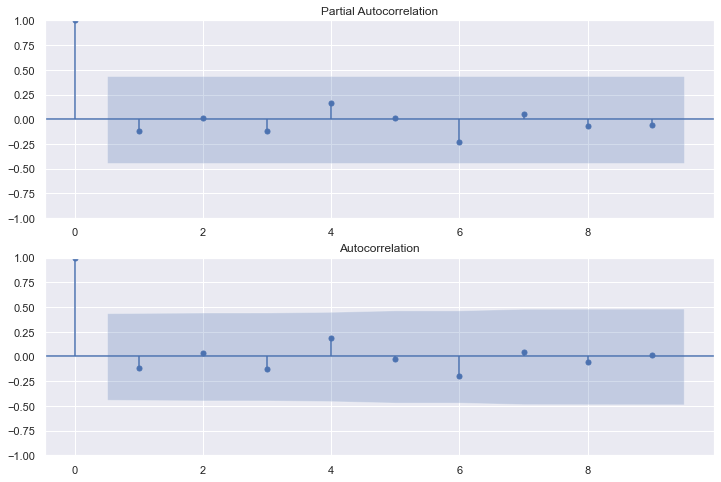

In [8]:
# arima for prediction
import statsmodels.api as sm
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8)) 
ax1=fig.add_subplot(212) 
fig = sm.graphics.tsa.plot_acf(df1,lags = 9,ax=ax1) 
ax2 = fig.add_subplot(211) 
fig = sm.graphics.tsa.plot_pacf(df1,lags = 9, ax=ax2, method='ywm')


From partial autocorrelation: set p = 0

From autocorrelation: set q = 0

In [10]:
# set p = 0, d = 1, q = 0
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['consumption'].dropna(), order = (0, 1, 0))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            consumption   No. Observations:                   21
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -486.286
Date:                Tue, 06 Dec 2022   AIC                            974.571
Time:                        19:36:29   BIC                            975.567
Sample:                             0   HQIC                           974.766
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.327e+19   2.39e+19      3.067      0.002    2.64e+19     1.2e+20
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 2.76
Prob(Q):                              0.57   Prob(JB):                         0.25
Heteroskedasticity (H):               2.55   Skew:                            -0.91
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

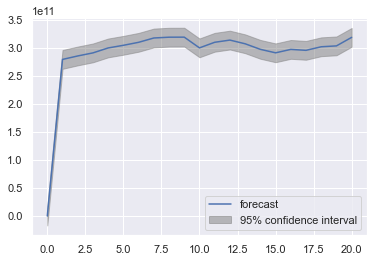

In [11]:
# Actual vs Fitted
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(fitted, dynamic=False)
plt.show()

In [25]:
predict = fitted.predict(start = 21, end = 30, dynamic = False)
df_preidct = pd.DataFrame(predict)
df_complete = pd.concat([df, df_preidct], axis = 1)
df_complete.set_index("year", inplace = True)
df_complete

,consumption,predicted_mean
year,,
2000-01-01,2.793196e+11,NaN
2001-01-01,2.854919e+11,NaN
2002-01-01,2.909596e+11,NaN
2003-01-01,2.997886e+11,NaN
2004-01-01,3.044897e+11,NaN
...,...,...
2091-01-01,NaN,NaN
2092-01-01,NaN,NaN
2093-01-01,NaN,NaN


<AxesSubplot:xlabel='year', ylabel='Demand for Electricity (kWh)'>

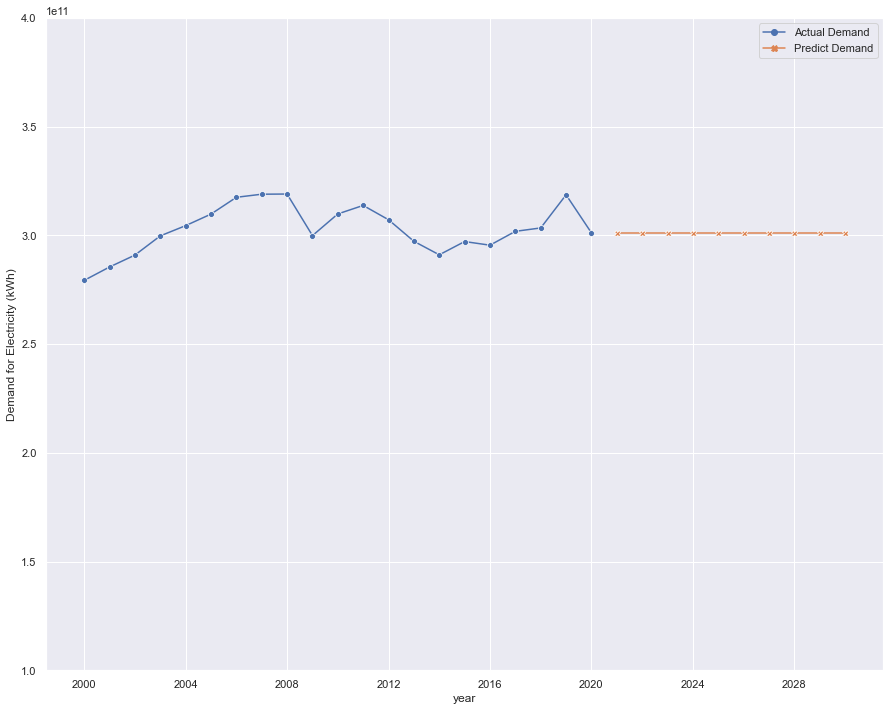

In [26]:
df_complete = df_complete.rename(columns = {'consumption':'Actual Demand', 'predicted_mean':'Predict Demand'})
g = sns.lineplot(data = df_complete, 
    markers=True, dashes=False)
g.set(ylim=(1*10**11, 4*10**11))
sns.set(rc={'figure.figsize':(15,12)})
g.set_ylabel('Demand for Electricity (kWh)')
g

In [14]:
predict = df_complete['Predict Demand'].tail(75)
predict.to_csv('demand_prediction_arima.csv')

# Smoothing

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


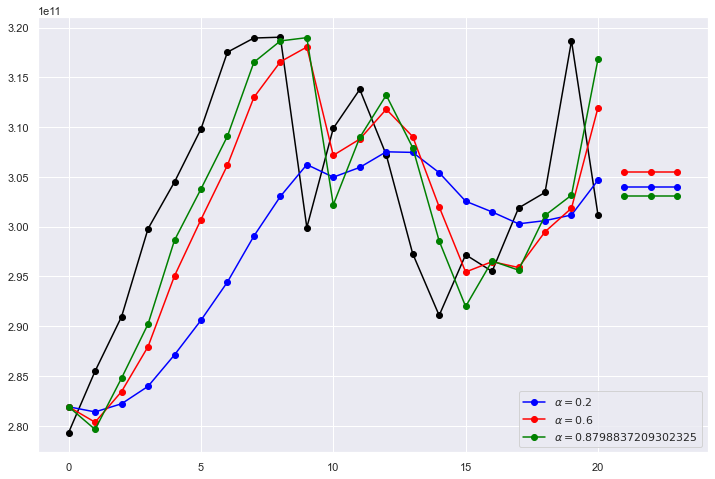

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

oildata = df['consumption'].dropna().copy()
fit1 = SimpleExpSmoothing(oildata, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(oildata, initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(oildata, initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(12, 8))
plt.plot(oildata, marker="o", color="black")
plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


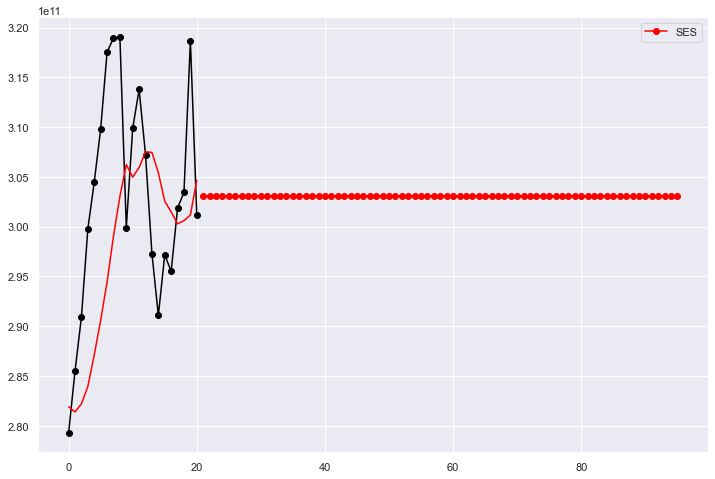

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

air =  df['consumption'].dropna().copy()
fit0 = SimpleExpSmoothing(air, initialization_method="estimated").fit()
fcast0 = fit0.forecast(75).rename("SES")
# fit1 = Holt(air, initialization_method="estimated").fit()
# fcast1 = fit1.forecast(75).rename("Holt's linear trend")
# # fit2 = Holt(air, exponential=True, initialization_method="estimated").fit()
# # fcast2 = fit2.forecast(75).rename("Exponential trend")
# fit3 = Holt(air, damped_trend=True, initialization_method="estimated").fit()
# fcast3 = fit3.forecast(75).rename("Additive damped trend")

plt.figure(figsize=(12, 8))
plt.plot(air, marker="o", color="black")
plt.plot(fit1.fittedvalues, color="red")
(line1,) = plt.plot(fcast0, marker="o", color="red")
# plt.plot(fit2.fittedvalues, color="red")
# (line2,) = plt.plot(fcast1, marker="o", color="red")
# plt.plot(fit3.fittedvalues, color="green")
# (line3,) = plt.plot(fcast3, marker="o", color="green")
# plt.legend([line1, line2, line3], [fcast0.name, fcast1.name, fcast3.name])
plt.legend([line1], [fcast0.name])




In [17]:
fcast0.to_csv("demand_prediction_ses.csv")

NameError: name 'fcast0' is not defined

References:
https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.statista.com/statistics/799638/total-electricity-consumption-in-italy/

https://www.statsmodels.org/v0.12.0/generated/statsmodels.tsa.arima_model.ARIMA.predict.html


